In [2]:

#-----------------------------------------------------------
# IMPORT ALL NECESSARY MODULES
#-----------------------------------------------------------

import numpy as np
%matplotlib inline 
import pandas as pd
import tensorflow as tf
from IPython.display import display, Image
import cv2
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.utils import plot_model
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

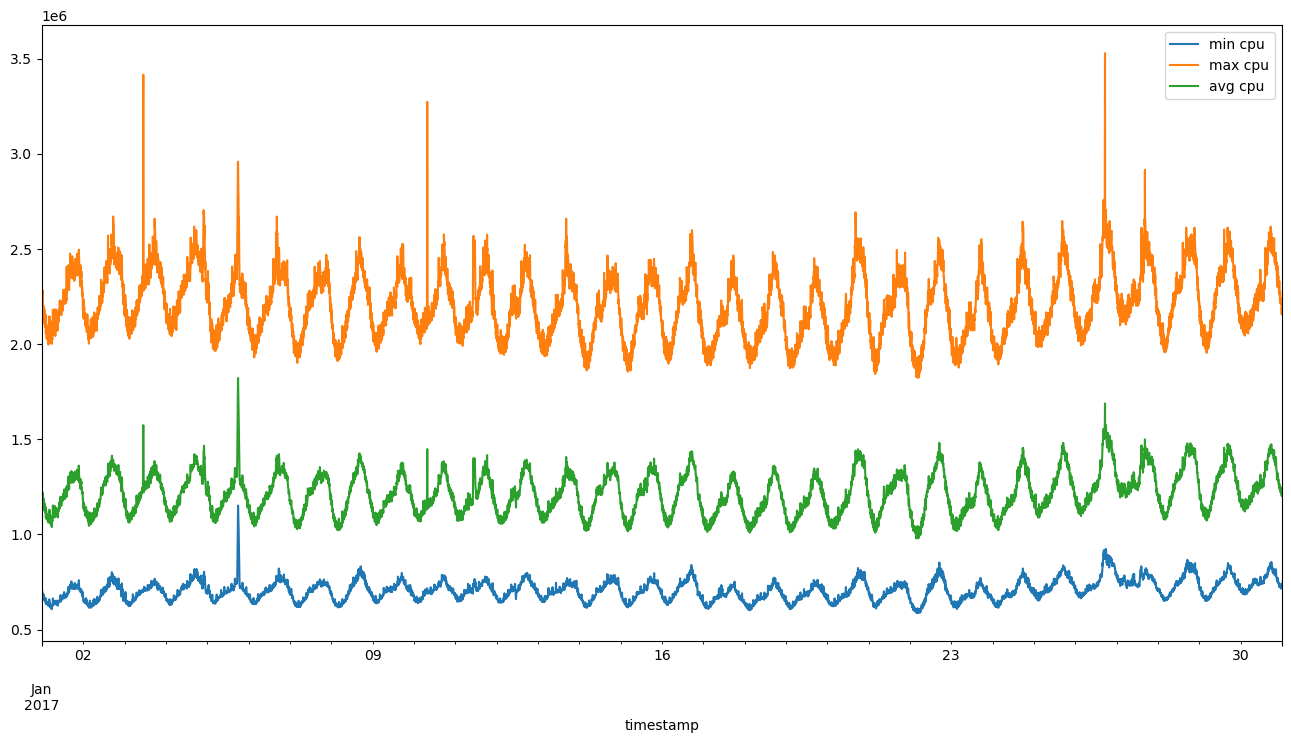

In [3]:

#-----------------------------------------------------------
# LOAD THE DATASET AND PLOT THE OBSERVATIONS
#-----------------------------------------------------------

df = pd.read_csv('azure.csv')
df['timestamp'] =  pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df.head()
df.plot(figsize=(16, 8))
plt.show()

In [4]:
#-----------------------------------------------------------
# CREATE TRAIN-TEST SPLIT (80:20)
#-----------------------------------------------------------
TRAIN_LENGTH = round(len(df)*0.8)
TEST_LENGTH = len(df) - TRAIN_LENGTH
train = df.iloc[0:TRAIN_LENGTH]
test = df[TRAIN_LENGTH : ]

In [5]:
#-----------------------------------------------------------
# SCALING VALUES
#-----------------------------------------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=df.columns)

In [6]:
#-----------------------------------------------------------
# GENERATOR TO DATA TO FEED INTO MODEL
#-----------------------------------------------------------
def train_generator(dataset, n_lags=1):
    dataX, dataY = [], []
    for i in range(len(dataset)- n_lags -1):
        a = dataset.iloc[i:(i+n_lags)].to_numpy()
        dataX.append(a)
        dataY.append(dataset.iloc[i + n_lags].to_numpy())
    return (np.array(dataX), np.array(dataY))

In [7]:
#-----------------------------------------------------------
# DEFINING INPUTS AND EXPECTED OBSERVATIONS
#-----------------------------------------------------------
TIME_STEPS = 500
X_train, y_train = train_generator(train_scaled, n_lags = TIME_STEPS)
X_test_scaled, y_test_scaled = train_generator(test_scaled, n_lags = TIME_STEPS)
X_test, y_test = train_generator(test, n_lags = TIME_STEPS)

In [8]:
#-----------------------------------------------------------
# USING A LSTM MODEL FOR PREDICTION ON TIME SERIES
#-----------------------------------------------------------
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(512,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(tf.keras.layers.LSTM(512,return_sequences=False))
model.add(tf.keras.layers.Dense(3))
model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 500, 512)       │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,157,507 (12.04 MB)

 Trainable params: 3,157,507 (12.04 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(loss='mean_absolute_error', optimizer= tf.keras.optimizers.Adam())

In [12]:
#-----------------------------------------------------------
# DEFINING CALLBACKS
#-----------------------------------------------------------
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)


In [13]:
callbacks = [es , lr_red]
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    validation_split=0.25,
                    batch_size=256,
                    verbose=1, 
                    shuffle=False, 
                    callbacks = callbacks)

#-----------------------------------------------------------
# I TRAINED MY MODEL ON BATCHSIZES - 64,128,256
#-----------------------------------------------------------

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 216s 11s/step - loss: 0.1006 - val_loss: 0.0360 - learning_rate: 0.0010
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 203s 11s/step - loss: 0.0299 - val_loss: 0.0268 - learning_rate: 0.0010
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 207s 11s/step - loss: 0.0300 - val_loss: 0.0216 - learning_rate: 0.0010
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 217s 11s/step - loss: 0.0264 - val_loss: 0.0220 - learning_rate: 0.0010
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 210s 11s/step - loss: 0.0249 - val_loss: 0.0205 - learning_rate: 0.0010
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 214s 11s/step - loss: 0.0234 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 225s 12s/step - loss: 0.0228 - val_loss: 0.0196 - learning_rate: 0.0010
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 225s 12s/step - loss: 0.0212 - val_loss: 0.0195 - learning_rate: 0.0010
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 226s 12s/step - loss: 0.0216 - val_loss: 0.0196 - learning_rate: 0.0010
Epoch 10/1

39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 885ms/step


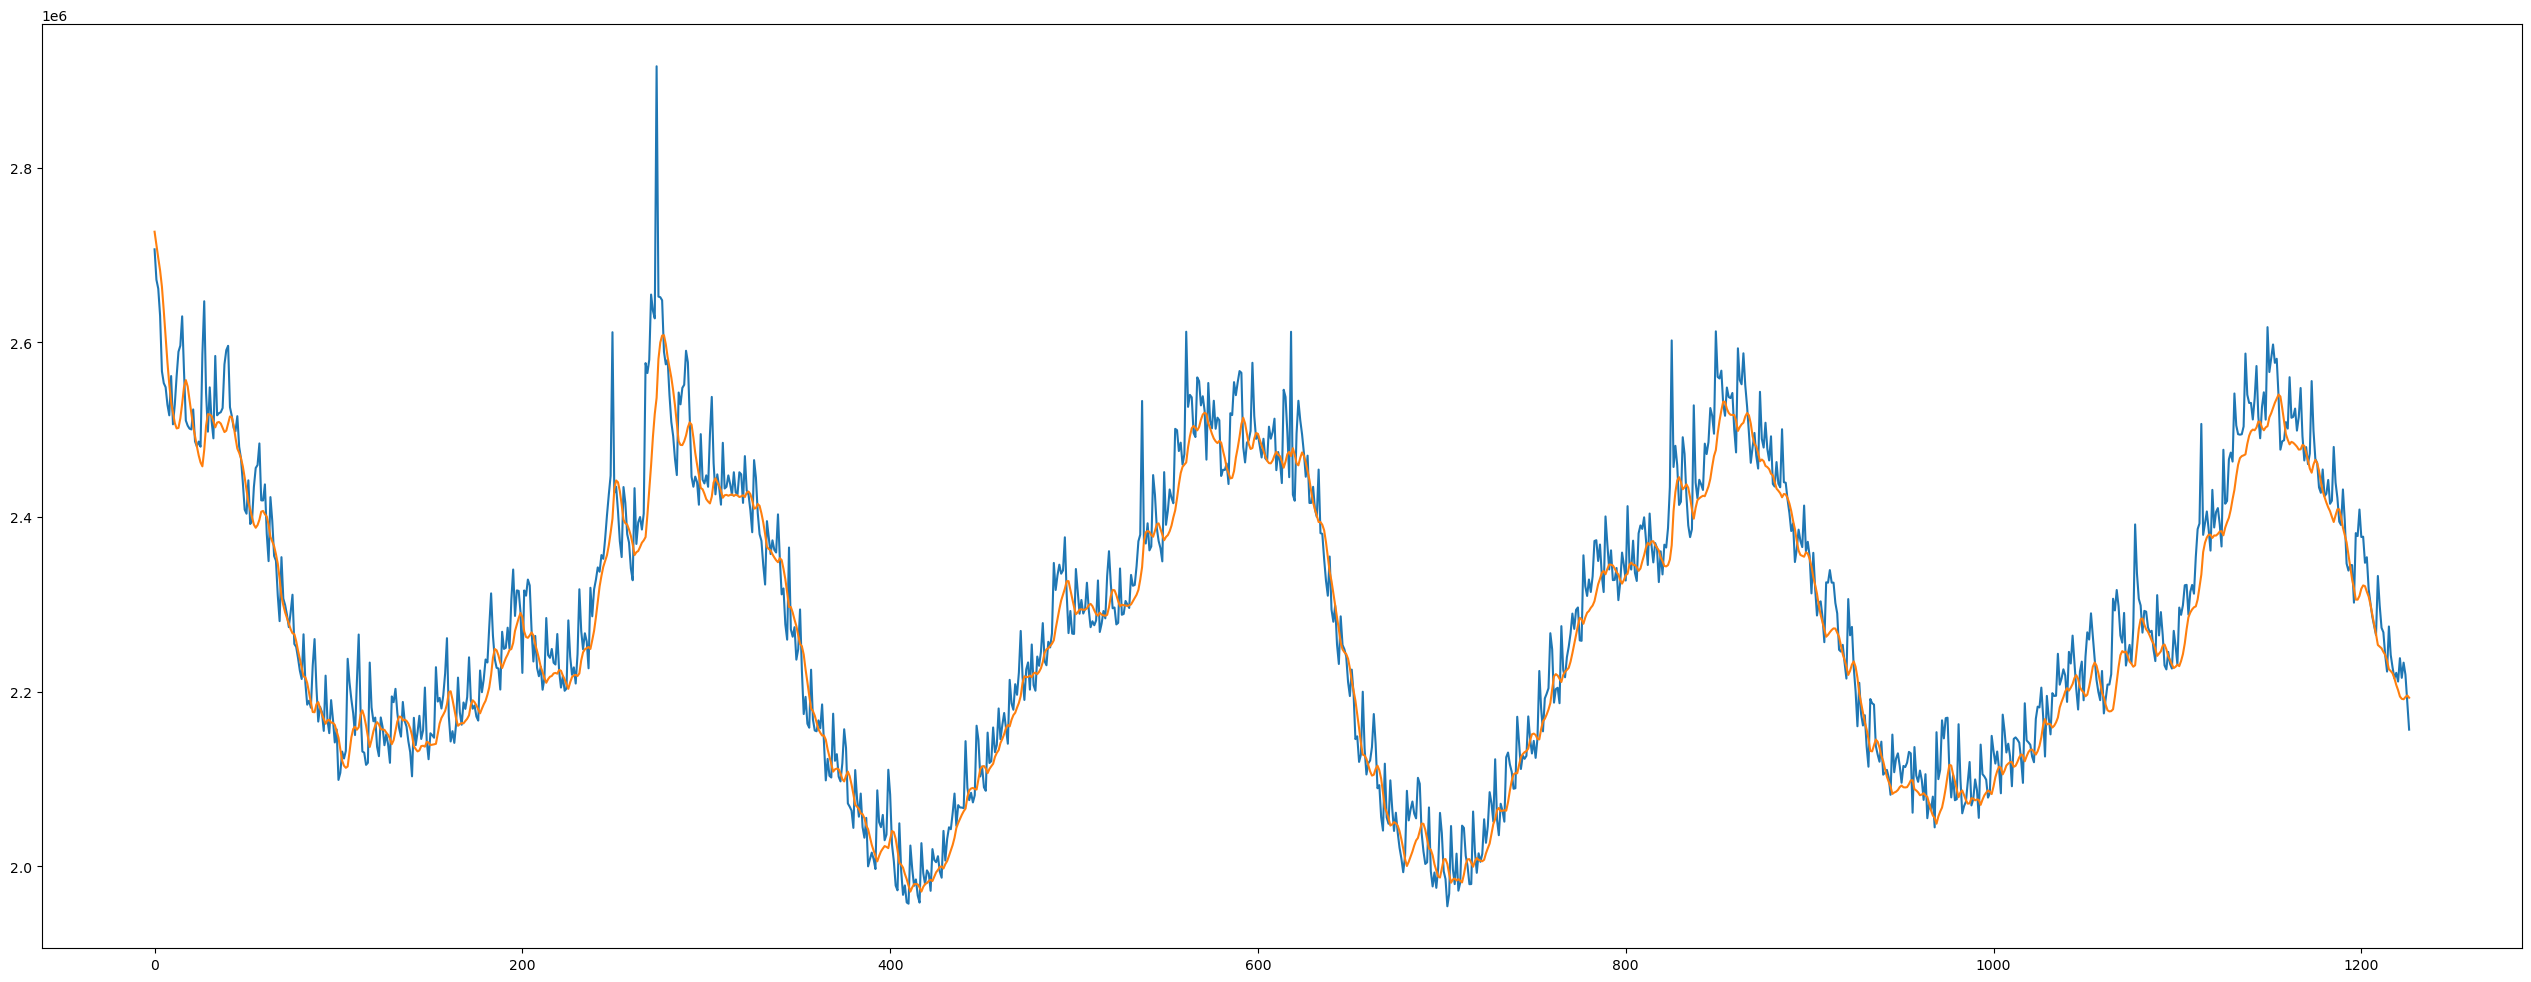

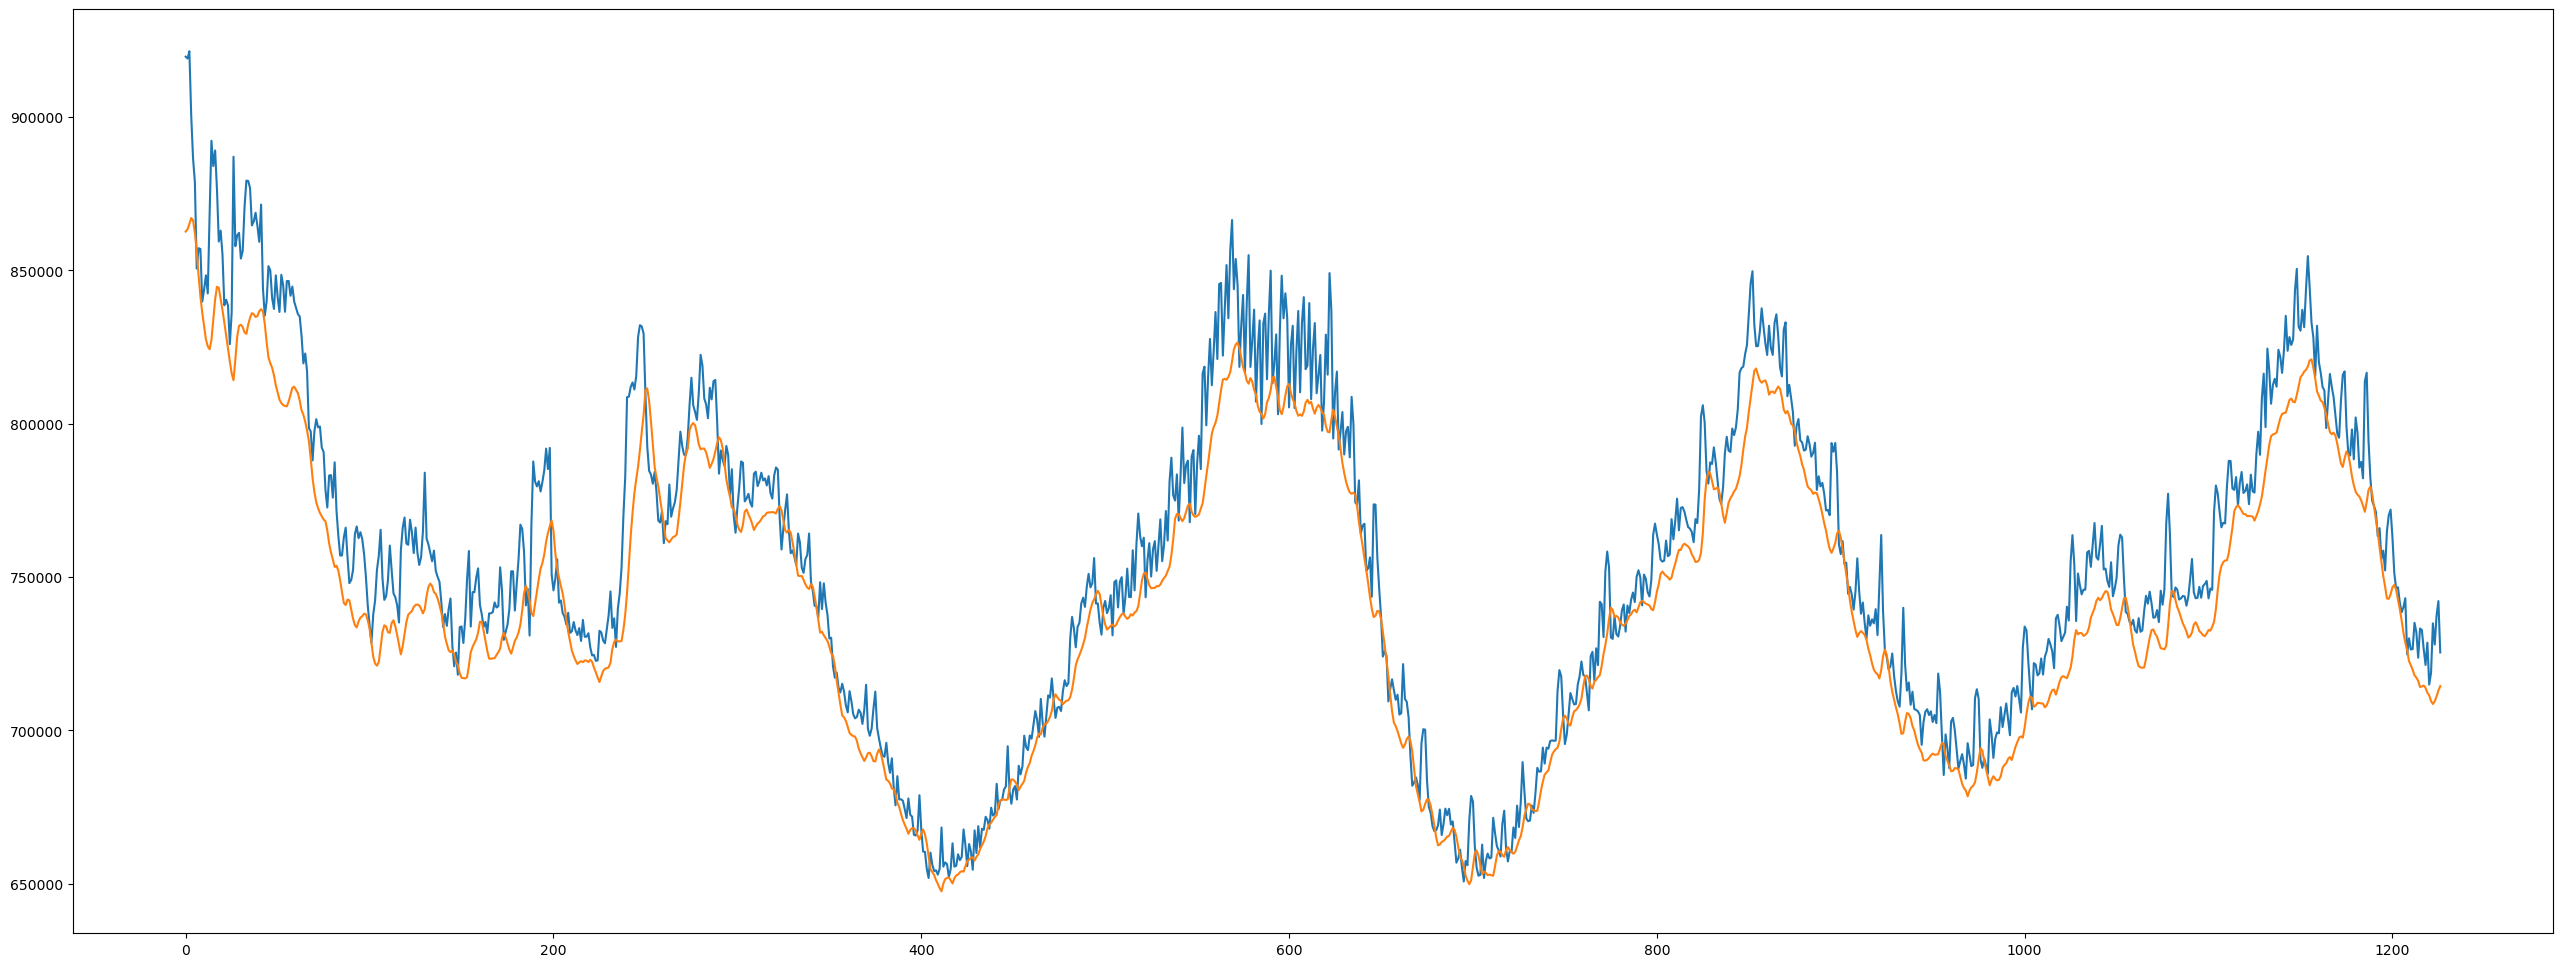

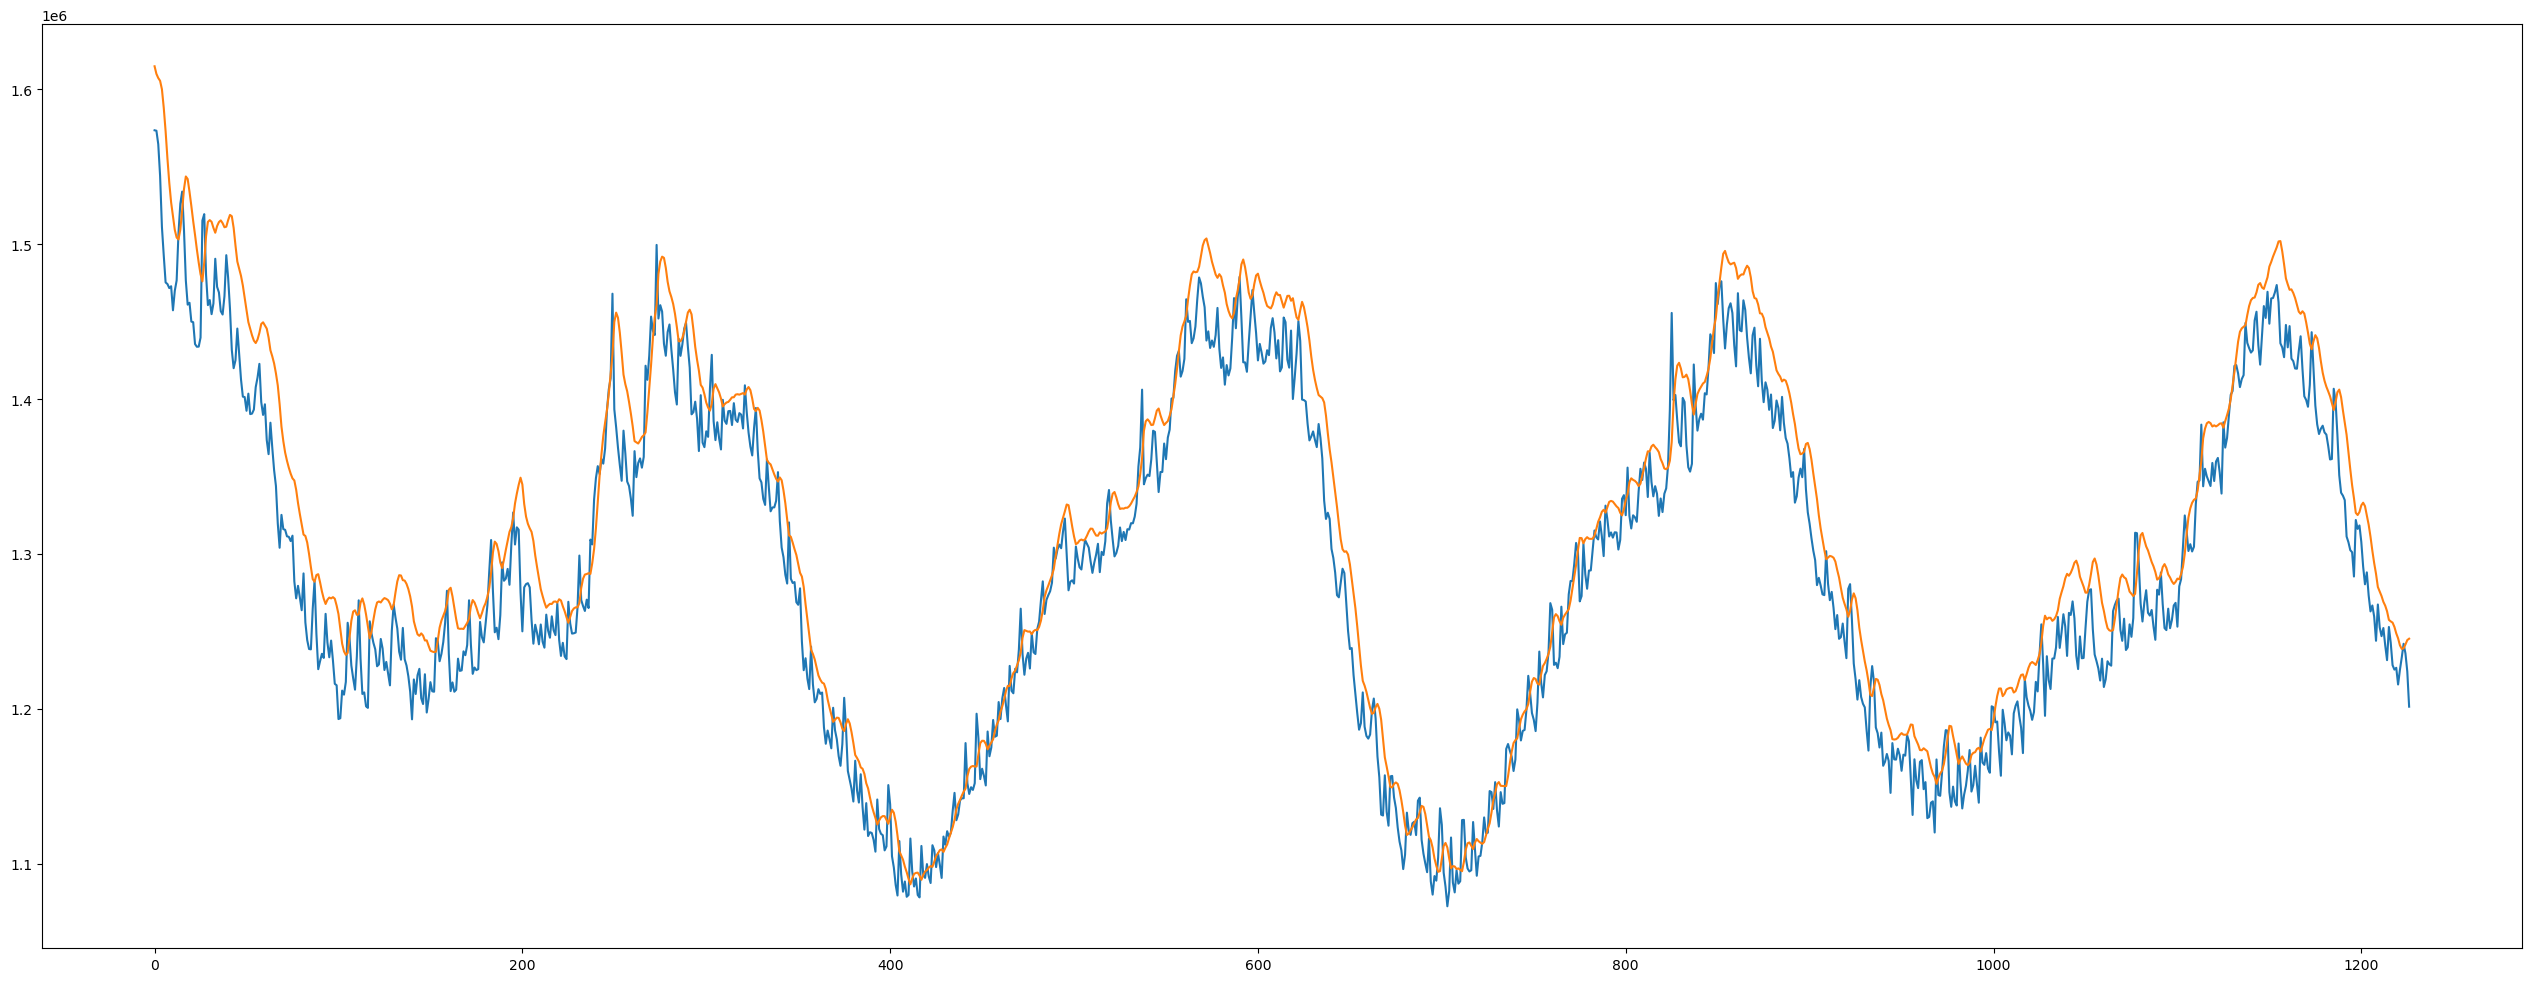

In [14]:
#-----------------------------------------------------------
# MAKING PREDICTIONS ON TEST DATA AND PLOTTING PREDICTED AND
# OBSERVED VALUES
#-----------------------------------------------------------
preds = model.predict(X_test_scaled)
preds = scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY= pd.DataFrame(y_test,columns=['min_cpu','max_cpu','avg_cpu'])
PredY=pd.DataFrame(preds,columns=['min_cpu','max_cpu','avg_cpu'])


plot_max = plt.figure(1)
plt.plot(TestY['max_cpu'])
plt.plot(PredY['max_cpu'])
plt.show()

plot_min = plt.figure(2)
plt.plot(TestY['min_cpu'])
plt.plot(PredY['min_cpu'])
plt.show()

plot_avg = plt.figure(3)
plt.plot(TestY['avg_cpu'])
plt.plot(PredY['avg_cpu'])
plt.show()

In [15]:
#-----------------------------------------------------------
# LETS CHECK HOW GOOD THE MODEL PERFORMED
#-----------------------------------------------------------
testScore_1 = math.sqrt(mean_squared_error(y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - y_test)/np.abs(y_test)*100)
print('Test Score: %f MAPE' % (testScore_3))

Test Score: 33368.51 RMSE
Test Score: 155.961005 MAE
Test Score: 1.754594 MAPE
